In [ ]:
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.stats as stats
# import japanize_matplotlib
import time
from numba import jit, njit

In [ ]:
class Model:

    def __init__(self,mu,beta,delta,alpha,b,Nl,s,prob,labor):

        self.mu   = mu          # risk aversion (=3 baseline)
        self.beta = beta        # subjective discount factor
        self.delta = delta      # depreciation
        self.alpha = alpha      # capital's share of income
        self.b = b              # borrowing limit
        self.Nl = Nl            # number of discretized states
        self.s = s              # (exponentialed) discretized states of log labor earnings
        self.prob = prob        # transition matrix of the Markov chain
        self.labor = labor      # aggregate labor supply

In [ ]:
def cdf_normal(x):
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x:
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    c = stats.norm.cdf(x,loc=0,scale=1)

    return c

In [ ]:
def tauchen(N,rho,sigma,m):
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'= ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    ・Zinv: Zの定常分布
    """
    Zprob = np.zeros((N,N)) # 遷移確率の行列
    Zinv = np.zeros((N,1))  # 定常分布

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*np.sqrt(sigma**2/(1-rho**2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z = np.linspace(zmin,zmax,N)

    # グリッド所与として遷移確率を求める
    for j in range(N): # 今期のZのインデックス
        for k in range(N): # 来期のZのインデックス
            if k == 0: # Pythonのインデックスは0から始まる(ここでは0からN-1)
                Zprob[j,k] = cdf_normal((Z[k]-rho*Z[j]+w/2)/sigma)
            elif k == N-1:
                Zprob[j,k] = 1 - cdf_normal((Z[k]-rho*Z[j]-w/2)/sigma)
            else:
                Zprob[j,k] = cdf_normal((Z[k]-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-rho*Z[j]-w/2)/sigma)

    # 定常分布を求める
    dist0 = (1/N) * np.ones(N)
    dist1 = np.copy(dist0)

    err = 1.0
    errtol = 1e-8
    iter = 1
    while err>errtol:
        dist1 = Zprob.T @ dist0
        err = sum(abs(dist0-dist1))
        dist0 = np.copy(dist1)
        iter += 1

    Zinv = np.copy(dist1)

    return Z,Zprob,Zinv

In [ ]:
@jit
def aiyagari_vfi1(m, r):
    """
    ---------------------------------------------------------
    === Computes Aggregate Savings given Interest Rate r ===
    ---------------------------------------------------------
    <input>
    ・m: model structure that contains parameters
    ・r: interest Rate
    <output>
    ・meank: aggregate savings given interest rate
    ・kfun:  policy function
    ・gridk: asset grid
    """
    # wage as a function of interest rate
    wage = (1 - m.alpha) * ((m.alpha / (r + m.delta)) ** m.alpha) ** (1 / (1 - m.alpha))

    # borrowing limit
    if r <= 0.0:
        phi = m.b
    else:
        phi = min(m.b, wage * m.s[0] / r)

    # capital grid
    Nk = 100
    maxK = 20
    minK = -phi
    gridk = np.linspace(minK, maxK, Nk)

    # initialize variables
    kfunG = np.zeros((m.Nl, Nk))
    kfun = np.zeros((m.Nl, Nk))
    v = np.zeros((m.Nl, Nk))
    tv = np.zeros((m.Nl, Nk))
    kfunG_old = np.zeros((m.Nl, Nk))

    err = 10
    maxiter = 2000
    iter = 1

    while (err > 0.0) and (iter < maxiter):
        for kc in range(Nk): # k
            for lc in range(m.Nl): # l
                kccmax = Nk
                vtemp = -1000000 * np.ones(Nk)
                for kcc in range(Nk): # k'
                    cons = m.s[lc] * wage + (1 + r) * gridk[kc] - gridk[kcc]
                    if cons <= 0.0:
                        kccmax = kcc
                        break
                    util = (cons ** (1 - m.mu)) / (1 - m.mu)
                    vpr = 0.0
                    for lcc in range(m.Nl):
                        vpr += m.prob[lc, lcc] * v[lcc, kcc]
                    vtemp[kcc] = util + m.beta * vpr
                # find k' that solves bellman equation
                t2 = np.argmax(vtemp[:kccmax])
                t1 = vtemp[t2]
                tv[lc, kc] = t1
                kfunG[lc, kc] = t2
                kfun[lc, kc] = gridk[t2]
        v = tv.copy()
        err = np.max(np.abs(kfunG - kfunG_old))
        kfunG_old = kfunG.copy()
        iter += 1

    # calculate stationary distribution
    mea0 = np.ones((m.Nl, Nk)) / (m.Nl * Nk)
    mea1 = np.zeros((m.Nl, Nk))
    err = 1
    errTol = 1e-5
    maxiter = 2000
    iter = 1

    while (err > errTol) and (iter < maxiter):
        for kc in range(Nk):
            for lc in range(m.Nl):
                kcc = int(kfunG[lc, kc])
                for lcc in range(m.Nl):
                    mea1[lcc, kcc] += m.prob[lc, lcc] * mea0[lc, kc]
        err = np.max(np.abs(mea1 - mea0))
        mea0 = mea1.copy()
        iter += 1
        mea1 = np.zeros((m.Nl, Nk))

    meank = np.sum(mea0 * kfun)

    return meank, kfun, gridk

In [ ]:
@jit
def aiyagari_vfi2(mu,beta,delta,alpha,b,Nl,s,prob,r):
    """
    ---------------------------------------------------------
    === Computes Aggregate Savings given Interest Rate r ===
    ---------------------------------------------------------
    <input>
    ・mu: risk aversion
    ・beta: subjective discount factor
    ・delta: depreciation
    ・alpha: capital's share of income
    ・b: borrowing limit
    ・Nl: number of discretized states
    ・s: (exponentialed) discretized states of log labor earnings
    ・prob: transition matrix of the Markov chain
    ・r: interest Rate
    <output>
    ・meank: aggregate savings given interest rate
    ・kfun:  policy function
    ・gridk: asset grid(state)
    """

    # write wage as a function of interest rate
    wage = (1-alpha)*((alpha/(r+delta))**alpha)**(1/(1-alpha))

    # borrowing limit
    if r <= 0.0:
        phi = b
    else:
        phi = min(b,wage*s[0]/r)

    # -phi is borrowing limit, b is adhoc
    # the second term is natural limit

    # capital grid (need define in each iteration since it depends on r/phi)
    Nk = 300                                     # grid size for STATE
    maxK = 20                                    # maximum value of capital grid
    minK = -phi                                  # borrowing constraint
    curvK = 2.0

    gridk = np.zeros(Nk)
    gridk[0] = minK
    for kc in range(1,Nk): # index
        gridk[kc]=gridk[0]+(maxK-minK)*((kc)/(Nk-1))**curvK



    Nk2 = 800                                     # grid size for CONTROL
    gridk2 = np.zeros(Nk2)
    gridk2[0] = minK
    for kc in range(1,Nk2): # index
        gridk2[kc]=gridk2[0]+(maxK-minK)*((kc)/(Nk2-1))**curvK


    # =================================================== #
    #  SPLIT GRID in gridk2 TO NEARBY TWO GRIDS IN gridk  #
    # =================================================== #

    # calculate node and weight for interpolation
    kc1vec=np.zeros(Nk2)
    kc2vec=np.zeros(Nk2)

    prk1vec=np.zeros(Nk2)
    prk2vec=np.zeros(Nk2)

    for kc in range(Nk2):

        xx = gridk2[kc]

        if xx >= gridk[Nk-1]: # index

            kc1vec[kc] = Nk-1 # index
            kc2vec[kc] = Nk-1 # index

            prk1vec[kc] = 1.0
            prk2vec[kc] = 0.0

        else:

            ind = 0 # index
            while xx > gridk[ind+1]:
                ind += 1
                if ind+1 >= Nk-1: # index
                    break

            kc1vec[kc] = ind

            if ind < Nk-1: # index

                kc2vec[kc] = ind+1
                dK=(xx-gridk[ind])/(gridk[ind+1]-gridk[ind])
                prk1vec[kc] = 1.0-dK
                prk2vec[kc] = dK

            else:

                kc2vec[kc] = ind
                prk1vec[kc] = 1.0
                prk2vec[kc] = 0.0


    # initialize some variables
    kfunG = np.zeros((Nl,Nk))       # new index of policy function
    kfun = np.zeros((Nl,Nk))        # new index of policy function
    # kfun = np.zeros_like(kfunG)      # policy function
    v = np.zeros((Nl,Nk))           # old value function
    tv = np.zeros((Nl,Nk))          # new value function
    # tv = np.zeros_like(kfunG)        # new value function
    kfunG_old = -1*np.ones((Nl,Nk)) # old policy function

    err     = 10   # error between old policy index and new policy index
    maxiter = 2000 # maximum number of iteration
    iter    = 1    # iteration counter

    while (err > 0) & (iter < maxiter):

        # tabulate the utility function such that for zero or negative
        # consumption utility remains a large negative number so that
        # such values will never be chosen as utility maximizing

        for kc in range(Nk): # k(STATE)
            for lc in range(Nl): # l

                kccmax = Nk2-1 # maximum index that satisfies c>0.0
                vtemp = -1000000 * np.ones(Nk2) # initizalization

                for kcc in range(Nk2): # k'(CONTROL)

                    # amount of consumption given (k,l,k')
                    cons = s[lc]*wage + (1+r)*gridk[kc] - gridk2[kcc]

                    if cons <= 0.0:
                        # penalty for c<0.0
                        # once c becomes negative, vtemp will not be updated(=large negative number)
                        kccmax = kcc-1
                        break

                    util = (cons**(1-mu)) / (1-mu)

                    # interpolation of next period's value function
                    # find node and weight for gridk2 (evaluating gridk2 in gridk)
                    kcc1 = int(kc1vec[kcc])
                    kcc2 = int(kc2vec[kcc])

                    vpr = 0.0 # next period's value function given (l,k')
                    for lcc in range(Nl): # expectation of next period's value function

                        vpr += prob[lc,lcc]*(prk1vec[kcc]*v[lcc,kcc1] + prk2vec[kcc]*v[lcc,kcc2])

                    vtemp[kcc] = util + beta*vpr

                # find k' that  solves bellman equation
                t1 = np.max(vtemp[1:kccmax]) # subject to k' achieves c>0
                t2 = np.argmax(vtemp[1:kccmax])
                tv[lc,kc] = t1
                kfunG[lc,kc] = t2
                kfun[lc,kc] = gridk2[t2]

        v = np.copy(tv)
        err = np.max(np.abs(kfunG-kfunG_old))
        # print(np.array([iter,err]))
        # flush(stdout)
        kfunG_old = np.copy(kfunG)
        iter += 1

    # if iter == maxiter:
    #     print("WARNING!! @aiyagari_vfi2.jl VFI: iteration reached max: iter=$iter,err=$err")

    # calculate stationary distribution
    mea0=np.ones((Nl,Nk))/(Nl*Nk) # old distribution
    mea1=np.zeros((Nl,Nk)) # new distribution
    err=1
    errTol=0.00001
    maxiter=2000
    iter=1

    while (err > errTol) & (iter < maxiter):

        for kc in range(Nk): # k
            for lc in range(Nl): # l

                kcc = int(kfunG[lc,kc]) # index of k'(k,l)

                # interpolation of policy function
                # split to two grids in gridk
                kcc1 = int(kc1vec[kcc])
                kcc2 = int(kc2vec[kcc])

                for lcc in range(Nl): # l'

                    mea1[lcc,kcc1] += prob[lc,lcc]*prk1vec[kcc]*mea0[lc,kc]
                    mea1[lcc,kcc2] += prob[lc,lcc]*prk2vec[kcc]*mea0[lc,kc]

        err = np.max(np.abs(mea1-mea0))
        # print(np.array([iter,err]))
        mea0 = np.copy(mea1)
        iter += 1
        mea1 = np.zeros((Nl,Nk))

    # if iter == maxiter
    #     println("WARNING!! @aiyagari_vfi2.jl INVARIANT DIST: iteration reached max: iter=$iter, err=$err")
    # end

    meank = np.sum(mea0 * kfun)

    return meank, kfun, gridk

In [ ]:
def aiyagari_vfi3(m, K):
    """
    Computes Aggregate Savings given Aggregate Capital K.
    Returns: meank (aggregate savings), kfun (policy function), gridk (asset state grid)
    """

    mu = m.mu
    beta = m.beta

    # Interest rate and wage
    r = m.alpha * ((K / m.labor) ** (m.alpha - 1)) - m.delta
    wage = (1 - m.alpha) * ((m.alpha / (r + m.delta)) ** m.alpha) ** (1 / (1 - m.alpha))

    # Borrowing limit
    if r <= 0.0:
        phi = m.b
    else:
        phi = min(m.b, wage * m.s[0] / r)

    Nk = 300
    maxK = 20
    minK = -phi
    curvK = 2.0

    # Asset grid for state
    gridk = np.zeros(Nk)
    gridk[0] = minK
    for kc in range(1, Nk):
        gridk[kc] = gridk[0] + (maxK - minK) * ((kc) / (Nk - 1)) ** curvK

    Nk2 = 800
    gridk2 = np.zeros(Nk2)
    gridk2[0] = minK
    for kc in range(1, Nk2):
        gridk2[kc] = gridk2[0] + (maxK - minK) * ((kc) / (Nk2 - 1)) ** curvK

    # Interpolation indices and weights
    kc1vec = np.zeros(Nk2, dtype=int)
    kc2vec = np.zeros(Nk2, dtype=int)
    prk1vec = np.zeros(Nk2)
    prk2vec = np.zeros(Nk2)
    for kc in range(Nk2):
        xx = gridk2[kc]
        if xx >= gridk[-1]:
            kc1vec[kc] = Nk - 1
            kc2vec[kc] = Nk - 1
            prk1vec[kc] = 1.0
            prk2vec[kc] = 0.0
        else:
            ind = 0
            while ind < Nk - 2 and xx > gridk[ind + 1]:
                ind += 1
            kc1vec[kc] = ind
            if ind < Nk - 1:
                kc2vec[kc] = ind + 1
                dK = (xx - gridk[ind]) / (gridk[ind + 1] - gridk[ind])
                prk1vec[kc] = 1.0 - dK
                prk2vec[kc] = dK
            else:
                kc2vec[kc] = ind
                prk1vec[kc] = 1.0
                prk2vec[kc] = 0.0

    Nl = m.Nl
    kfunG = np.zeros((Nl, Nk), dtype=int)
    kfun = np.zeros((Nl, Nk))
    v = np.zeros((Nl, Nk))
    tv = np.zeros_like(v)
    kfunG_old = np.zeros_like(kfunG)

    err = 10
    maxiter = 2000
    iter = 1

    while (err > 0) and (iter < maxiter):
        for kc in range(Nk):
            for lc in range(Nl):
                kccmax = Nk2
                vtemp = -1e6 * np.ones(Nk2)

                for kcc in range(Nk2):
                    cons = m.s[lc] * wage + (1 + r) * gridk[kc] - gridk2[kcc]
                    if cons <= 0.0:
                        kccmax = kcc
                        break
                    # Utility function (mu ≠ 1)
                    util = (cons ** (1 - mu)) / (1 - mu)
                    kcc1 = kc1vec[kcc]
                    kcc2 = kc2vec[kcc]
                    vpr = 0.0
                    # Expectation over labor states
                    for lcc in range(Nl):
                        vpr += m.prob[lc, lcc] * (prk1vec[kcc] * v[lcc, kcc1] + prk2vec[kcc] * v[lcc, kcc2])
                    vtemp[kcc] = util + beta * vpr

                # If no feasible control, set to minimal values
                if kccmax == 0:
                    tv[lc, kc] = -1e6
                    kfunG[lc, kc] = 0
                    kfun[lc, kc] = gridk2[0]
                    continue

                # Maximization
                t2 = np.argmax(vtemp[:kccmax])  # index
                t1 = vtemp[t2]                  # value
                tv[lc, kc] = t1
                kfunG[lc, kc] = t2
                kfun[lc, kc] = gridk2[t2]
        v[:] = tv
        err = np.max(np.abs(kfunG - kfunG_old))
        kfunG_old[:] = kfunG
        iter += 1

    # Stationary Distribution Calculation
    mea0 = np.ones((Nl, Nk)) / (Nl * Nk)
    mea1 = np.zeros((Nl, Nk))
    err = 1
    errTol = 1e-5
    maxiter = 2000
    iter = 1

    while (err > errTol) and (iter < maxiter):
        for kc in range(Nk):
            for lc in range(Nl):
                kcc = int(kfunG[lc, kc])
                kcc1 = kc1vec[kcc]
                kcc2 = kc2vec[kcc]
                for lcc in range(Nl):
                    mea1[lcc, kcc1] += m.prob[lc, lcc] * prk1vec[kcc] * mea0[lc, kc]
                    mea1[lcc, kcc2] += m.prob[lc, lcc] * prk2vec[kcc] * mea0[lc, kc]
        err = np.max(np.abs(mea1 - mea0))
        mea0[:] = mea1
        iter += 1
        mea1[:] = 0

    meank = np.sum(mea0 * kfun)
    return meank, kfun, gridk

In [ ]:
mu = 3.0
beta = 0.96
delta = 0.08
alpha = 0.36
b = 3.0

Nl = 7
rho = 0.6
sig = 0.4
M = 2.0

logs, prob, invdist = tauchen(Nl, rho, sig, M)
s = np.exp(logs)
labor = s @ invdist
print("logs:", logs)
print("prob:", prob)
print("invdist:", invdist)

m = Model(mu, beta, delta, alpha, b, Nl, s, prob, labor)

logs: [-1.         -0.66666667 -0.33333333  0.          0.33333333  0.66666667
  1.        ]
prob: [[2.79834464e-01 3.18871862e-01 2.61963427e-01 1.11690101e-01
  2.46603831e-02 2.81014461e-03 1.69618625e-04]
 [1.39330247e-01 2.61963427e-01 3.18871862e-01 2.01544260e-01
  6.60657309e-02 1.12009940e-02 1.02347866e-03]
 [5.66727546e-02 1.69954598e-01 3.06579399e-01 2.87134579e-01
  1.39599512e-01 3.51666203e-02 4.89253660e-03]
 [1.86104252e-02 8.70393485e-02 2.32811346e-01 3.23077761e-01
  2.32811346e-01 8.70393485e-02 1.86104252e-02]
 [4.89253660e-03 3.51666203e-02 1.39599512e-01 2.87134579e-01
  3.06579399e-01 1.69954598e-01 5.66727546e-02]
 [1.02347866e-03 1.12009940e-02 6.60657309e-02 2.01544260e-01
  3.18871862e-01 2.61963427e-01 1.39330247e-01]
 [1.69618625e-04 2.81014461e-03 2.46603831e-02 1.11690101e-01
  2.61963427e-01 3.18871862e-01 2.79834464e-01]]
invdist: [0.04656244 0.11152397 0.21136859 0.26108999 0.21136859 0.11152397
 0.04656244]


In [ ]:
rate0 = 0.02  # initial guess
adj = 0.001
ind = False

while not ind:
    K0 = m.labor * (m.alpha / (rate0 + m.delta)) ** (1 / (1 - m.alpha))  # capital demand
    K1 = aiyagari_vfi2(m.mu, m.beta, m.delta, m.alpha, m.b, m.Nl, m.s, m.prob, rate0)[0]  # asset supply
    if K0 < K1:
        ind = True

    print(f"ind: {ind}, rate0: {rate0:.4f}, K0: {K0:.4f}, K1: {K1:.4f}, diff: {K0-K1:.4f}")

    if not ind:
        rate0 += adj

ind: False, rate0: 0.0200, K0: 8.3301, K1: 3.3139, diff: 5.0162
ind: False, rate0: 0.0210, K0: 8.2016, K1: 3.4658, diff: 4.7358
ind: False, rate0: 0.0220, K0: 8.0763, K1: 3.6066, diff: 4.4697
ind: False, rate0: 0.0230, K0: 7.9541, K1: 3.7917, diff: 4.1624
ind: False, rate0: 0.0240, K0: 7.8349, K1: 3.9991, diff: 3.8358
ind: False, rate0: 0.0250, K0: 7.7186, K1: 4.1695, diff: 3.5491
ind: False, rate0: 0.0260, K0: 7.6051, K1: 4.3473, diff: 3.2578
ind: False, rate0: 0.0270, K0: 7.4944, K1: 4.5234, diff: 2.9710
ind: False, rate0: 0.0280, K0: 7.3862, K1: 4.7056, diff: 2.6807
ind: False, rate0: 0.0290, K0: 7.2806, K1: 4.8844, diff: 2.3962
ind: False, rate0: 0.0300, K0: 7.1775, K1: 5.0651, diff: 2.1124
ind: False, rate0: 0.0310, K0: 7.0767, K1: 5.2248, diff: 1.8520
ind: False, rate0: 0.0320, K0: 6.9782, K1: 5.4193, diff: 1.5590
ind: False, rate0: 0.0330, K0: 6.8820, K1: 5.6313, diff: 1.2507
ind: False, rate0: 0.0340, K0: 6.7879, K1: 5.8302, diff: 0.9576
ind: False, rate0: 0.0350, K0: 6.6959, K

Equilibrium rate: 0.0380, K0: 6.6896


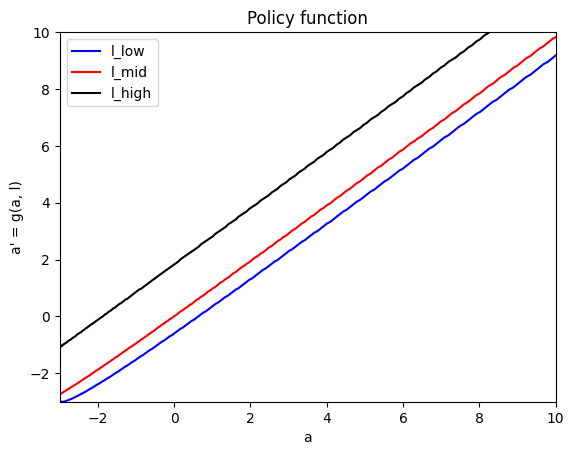

In [ ]:
K0, kfun0, gridk0 = aiyagari_vfi2(m.mu, m.beta, m.delta, m.alpha, m.b, m.Nl, m.s, m.prob, rate0)
print(f"Equilibrium rate: {rate0:.4f}, K0: {K0:.4f}")

plt.plot(gridk0, kfun0[0, :], color='blue', label='l_low')
plt.plot(gridk0, kfun0[3, :], color='red', label='l_mid')
plt.plot(gridk0, kfun0[6, :], color='black', label='l_high')
plt.title("Policy function")
plt.xlabel("a")
plt.ylabel("a' = g(a, l)")
plt.xlim(-3, 10)
plt.ylim(-3, 10)
plt.legend(loc='upper left')
plt.show()

In [ ]:
K0 = 6.8  # initial guess
err = 1
errTol = 0.001
maxiter = 100
iter = 1
adj = 0.2

while (err > errTol) and (iter < maxiter):
    K1, _, _ = aiyagari_vfi3(m, K0)  # K1 is aggregate savings, scalar
    if np.isnan(K1) or K1 == 0:
        print(f"K1 is nan or zero at iteration {iter}, aborting.")
        break
    err = abs(K0 - K1) / abs(K1)
    print(f"iter: {iter}, K0: {K0:.4f}, K1: {K1:.4f}, err: {err:.6f}")
    if err > errTol:
        K0 += adj * (K1 - K0)
        iter += 1

if iter == maxiter:
    print(f"WARNING!! iter={maxiter}, err={err}")

K0, kfun0, gridk0 = aiyagari_vfi3(m, K0)

iter: 1, K0: 6.8000, K1: -3.0000, err: 3.266667
iter: 2, K0: 4.8400, K1: -3.0000, err: 2.613333
iter: 3, K0: 3.2720, K1: -3.0000, err: 2.090667
iter: 4, K0: 2.0176, K1: -1.7310, err: 2.165581
iter: 5, K0: 1.2679, K1: -0.9690, err: 2.308493
iter: 6, K0: 0.8205, K1: -0.5824, err: 2.408829
iter: 7, K0: 0.5399, K1: -0.3643, err: 2.482236
iter: 8, K0: 0.3591, K1: -0.2336, err: 2.537147
iter: 9, K0: 0.2406, K1: -0.1524, err: 2.578785
iter: 10, K0: 0.1620, K1: -0.1006, err: 2.610645
iter: 11, K0: 0.1095, K1: -0.0669, err: 2.635176
iter: 12, K0: 0.0742, K1: -0.0448, err: 2.654147
iter: 13, K0: 0.0504, K1: -0.0302, err: 2.668867
iter: 14, K0: 0.0343, K1: -0.0204, err: 2.680317
iter: 15, K0: 0.0233, K1: -0.0138, err: 2.689240
iter: 16, K0: 0.0159, K1: -0.0094, err: 2.696202
iter: 17, K0: 0.0108, K1: -0.0064, err: 2.701641
iter: 18, K0: 0.0074, K1: -0.0043, err: 2.705893
iter: 19, K0: 0.0051, K1: -0.0030, err: 2.709220
iter: 20, K0: 0.0035, K1: -0.0020, err: 2.711823
iter: 21, K0: 0.0024, K1: -0.

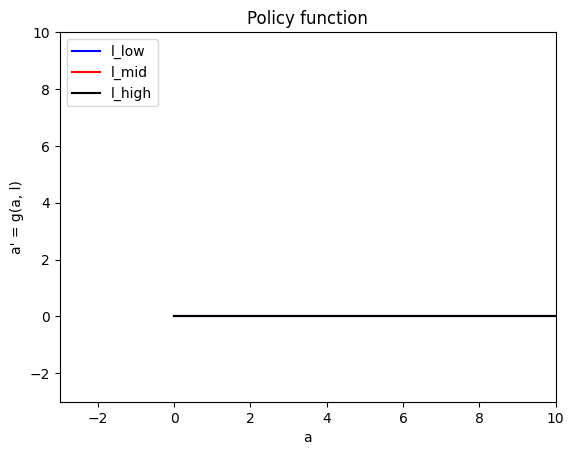

In [ ]:
plt.plot(gridk0, kfun0[0, :], color='blue', label='l_low')
plt.plot(gridk0, kfun0[3, :], color='red', label='l_mid')
plt.plot(gridk0, kfun0[6, :], color='black', label='l_high')
plt.title("Policy function")
plt.xlabel("a")
plt.ylabel("a' = g(a, l)")
plt.xlim(-3, 10)
plt.ylim(-3, 10)
plt.legend(loc='upper left')
plt.show()